# Spotify ETL Pipeline
This project demonstrates an end-to-end ETL (Extract, Transform, Load) pipeline using the Spotify API and Azure tools. 
Data is extracted from Spotify playlists, transformed, and prepared for storage.


### Installing Dependencies

In [1]:
# Install required libraries
!pip install spotipy pandas


###  Authentication with Spotify API

In [2]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth

# Spotify API credentials
client_id = "2203ef17b67c4cd08affbf355b164b0b"  # Client ID
client_secret = "8d5ccac168e146dfafe817e5b1e05fd0"  # Client Secret

# Authenticate with Spotify
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id=client_id,
    client_secret=client_secret,
    redirect_uri="http://localhost:6060/callback",
    scope="playlist-read-private"
))
print("Authentication successful!")

Authentication successful!


## Extract

### Extract Playlist Data

I will be choosing my personal favorite spotify playlist 'Rap' and extract the playlist data.

In [3]:
playlist_id = "2O6rARZJi8IoXLiUdXZPJ3" # Personal playlist
results = sp.playlist_tracks(playlist_id)


# Extract track details
track_data = []
for item in results['items']:
    track = item['track']
    track_data.append({
        'Track Name': track['name'],
        'Artist': track['artists'][0]['name'],
        'Album': track['album']['name'],
        'Release Date': track['album']['release_date'],
        'Popularity': track['popularity']
    })

# Display first 5 tracks
track_data[:5]

[{'Track Name': 'Toosie Slide',
  'Artist': 'Drake',
  'Album': 'Dark Lane Demo Tapes',
  'Release Date': '2020-05-01',
  'Popularity': 66},
 {'Track Name': 'Chicago Freestyle (feat. Giveon)',
  'Artist': 'Drake',
  'Album': 'Dark Lane Demo Tapes',
  'Release Date': '2020-05-01',
  'Popularity': 76},
 {'Track Name': 'Money In The Grave (Drake ft. Rick Ross)',
  'Artist': 'Drake',
  'Album': 'The Best In The World Pack',
  'Release Date': '2019-06-15',
  'Popularity': 73},
 {'Track Name': "God's Plan",
  'Artist': 'Drake',
  'Album': 'Scorpion',
  'Release Date': '2018-06-29',
  'Popularity': 81},
 {'Track Name': 'Nonstop',
  'Artist': 'Drake',
  'Album': 'Scorpion',
  'Release Date': '2018-06-29',
  'Popularity': 74}]

### Saving data to CSV

In [5]:
import pandas as pd

# Convert track data to a DataFrame
df = pd.DataFrame(track_data)

# Save to CSV
df.to_csv('rap_playlist_tracks.csv', index=False)
df.head()


,Track Name,Artist,Album,Release Date,Popularity
0,Toosie Slide,Drake,Dark Lane Demo Tapes,2020-05-01,66
1,Chicago Freestyle (feat. Giveon),Drake,Dark Lane Demo Tapes,2020-05-01,76
2,Money In The Grave (Drake ft. Rick Ross),Drake,The Best In The World Pack,2019-06-15,73
3,God's Plan,Drake,Scorpion,2018-06-29,81
4,Nonstop,Drake,Scorpion,2018-06-29,74


## Transform

### Transforming the Data

In this step, we will clean and prepare the extracted data for storage in a database. This includes tasks like normalizing fields, handling missing data, and adding calculated metrics.

In [6]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('rap_playlist_tracks.csv')

# Display the first few rows
df.head()


,Track Name,Artist,Album,Release Date,Popularity
0,Toosie Slide,Drake,Dark Lane Demo Tapes,2020-05-01,66
1,Chicago Freestyle (feat. Giveon),Drake,Dark Lane Demo Tapes,2020-05-01,76
2,Money In The Grave (Drake ft. Rick Ross),Drake,The Best In The World Pack,2019-06-15,73
3,God's Plan,Drake,Scorpion,2018-06-29,81
4,Nonstop,Drake,Scorpion,2018-06-29,74


Inspecting the data

In [7]:
# Display column data types and summary
print(df.info())

# Summary statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Track Name    96 non-null     object
 1   Artist        96 non-null     object
 2   Album         96 non-null     object
 3   Release Date  96 non-null     object
 4   Popularity    96 non-null     int64 
dtypes: int64(1), object(4)
memory usage: 3.9+ KB
None
       Popularity
count    96.00000
mean     64.81250
std      14.82978
min       0.00000
25%      58.75000
50%      66.00000
75%      74.25000
max      85.00000
Track Name      0
Artist          0
Album           0
Release Date    0
Popularity      0
dtype: int64


Converting 'Release Date' to datetime format

In [8]:
# Convert 'Release Date' to datetime and extract the year
df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce')
df['Release Year'] = df['Release Date'].dt.year


Scaling popularity to a range of 0–1

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['Popularity Scaled'] = scaler.fit_transform(df[['Popularity']])


In [11]:
df['Track Name Length'] = df['Track Name'].apply(len) # For Analysis

### Some basic visual insights

In [ ]:
import matplotlib.pyplot as plt

#### Lets find out the top 10 most frequent artists

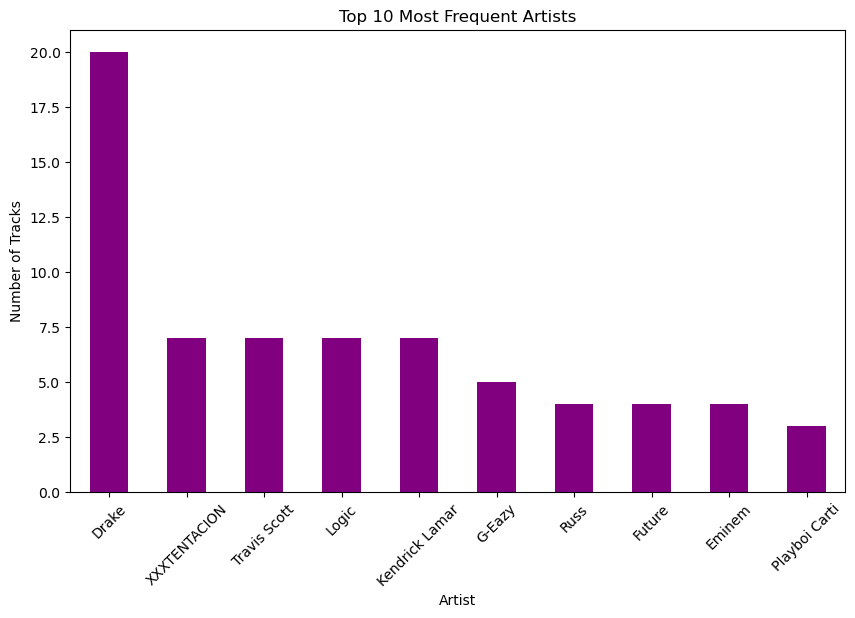

In [13]:
# Count the frequency of each artist
artist_counts = df['Artist'].value_counts().head(10)

# Plot the top 10 most frequent artists
plt.figure(figsize=(10, 6))
artist_counts.plot(kind='bar', color='purple')
plt.title('Top 10 Most Frequent Artists')
plt.xlabel('Artist')
plt.ylabel('Number of Tracks')
plt.xticks(rotation=45)
plt.show()


Hence confirmed Drake is definetely my favorite rapper.

#### Lets visualise top 10 most popular tracks

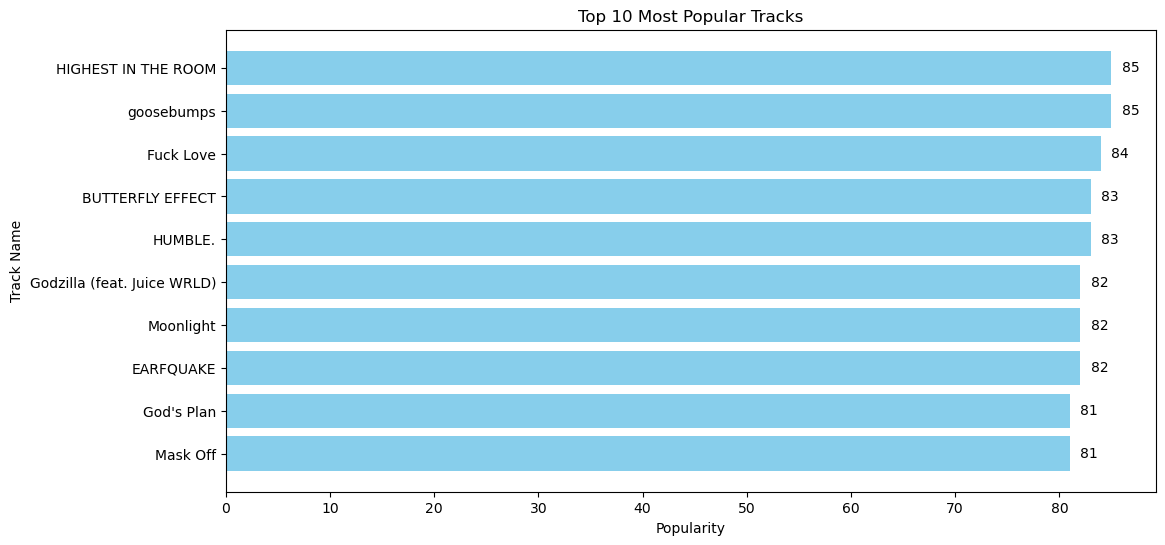

In [22]:
# Sort tracks by popularity and get top 10
top_10_tracks = df[['Track Name', 'Artist', 'Album', 'Popularity']].sort_values(by='Popularity', ascending=False).head(10)

# Plot a horizontal bar chart
plt.figure(figsize=(12, 6))
bars = plt.barh(top_10_tracks['Track Name'], top_10_tracks['Popularity'], color='skyblue')
plt.title('Top 10 Most Popular Tracks')
plt.xlabel('Popularity')
plt.ylabel('Track Name')
plt.gca().invert_yaxis()  # Highest popularity at the top

# Add popularity values on the bars
for bar in bars:
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,  # Position text at end of bar
             f'{bar.get_width():.0f}', va='center')

plt.show()



Ofcourse Travis Scott has the most popular songs at the top.

### Saving transformed data

In [25]:
# Save the transformed DataFrame
df.to_csv('rap_playlist_transformed.csv', index=False)
print("Transformed data saved to rap_playlist_transformed.csv")


Transformed data saved to rap_playlist_transformed.csv


## Load

In [3]:
!pip install pyodbc sqlalchemy pandas

Note: you may need to restart the kernel to use updated packages.


Connecting to Azure SQL database and loading the CSV file

In [5]:
from sqlalchemy import create_engine
import pandas as pd

# Load the transformed CSV data
df = pd.read_csv('rap_playlist_transformed.csv')

# Database connection details
server = 'spotify-sql-server.database.windows.net'  # Replace with your Azure SQL server
database = 'SpotifyDB'
username = 'SQL_server'  # SQL username
password = 'Tajmahal1'  # SQL password
driver = 'ODBC Driver 18 for SQL Server'

# Creating a database connection
connection_string = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver={driver}"
engine = create_engine(connection_string)

print("Connection Successful")


Connection Successful


In [6]:
# Write data to SQL table
table_name = 'RapPlaylist'
df.to_sql(table_name, engine, if_exists='replace', index=False)
print(f"Data successfully loaded into table '{table_name}'!")

Data successfully loaded into table 'RapPlaylist'!


In [7]:
query = f"SELECT * FROM {table_name}"

try:
    # Load SQL table into a DataFrame
    df = pd.read_sql(query, engine)
    print("Data successfully fetched from the SQL table.")
    display(df)
except Exception as e:
    print(f"Error fetching data: {e}")

Data successfully fetched from the SQL table.


,Track Name,Artist,Album,Release Date,Popularity,Release Year,Popularity Scaled,Track Name Length
0,Toosie Slide,Drake,Dark Lane Demo Tapes,2020-05-01,66,2020,0.776471,12
1,Chicago Freestyle (feat. Giveon),Drake,Dark Lane Demo Tapes,2020-05-01,76,2020,0.894118,32
2,Money In The Grave (Drake ft. Rick Ross),Drake,The Best In The World Pack,2019-06-15,73,2019,0.858824,40
3,God's Plan,Drake,Scorpion,2018-06-29,81,2018,0.952941,10
4,Nonstop,Drake,Scorpion,2018-06-29,74,2018,0.870588,7
...,...,...,...,...,...,...,...,...
91,"WHATS POPPIN (feat. DaBaby, Tory Lanez & Lil W...",Jack Harlow,"WHATS POPPIN (feat. DaBaby, Tory Lanez & Lil W...",2020-06-24,64,2020,0.752941,59
92,WHATS POPPIN,Jack Harlow,Sweet Action,2020-03-13,73,2020,0.858824,12
93,CrasH,ScHoolboy Q,CrasH Talk,2019-04-26,58,2019,0.682353,5
94,Said N Done,21 Savage,SAVAGE MODE II,2020-10-02,57,2020,0.670588,11
